### Meta Labeling

베팅(매도 또는 매수)의 방향을 설정하는 모델을 이미 갖고 있는 상황을 가정해 보자. 이 경우에는 베팅의 크기만 알면 되는데, 베팅이 없을 가능성도 있다. 이는 현업에서 항상 겪는 상황이기도 하다. 우리는 대개 매수할 것인지 매도할 것인지를 알고 있으므로, 남은 문제는 얼마를 집행할 것인지를 결정하는 것이다. 단지 머신러닝 알고리즘이 매수 매도 등 베팅의 방향을 학습한 후 적절한 베팅 크기가 무엇인지 쉽게 알려 주기를 원하지 않는다. 아마도 이 문제에 관한 어떠한 책이나 논문이 나오지 않았다는 것에 이미 익숙해져 버렸을 수 있다

다행히 이 문제를 여기서 해결해 볼 수 있다. Lopez de Prado는 이 문제를 Meta Labeling이라 부르는데 그 이유는 1차 외생 모델을 어떻게 사용할지 학습하는 부수적인 머신러닝 모델을 구축하고자 하기 때문이다

아래의 과정은 Triple Barrier Method에서 구축한 방법과 동일한 과정이다.

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from FinancialMachineLearning.labeling.labeling import *
from FinancialMachineLearning.features.volatility import daily_volatility

start_date = '2000-01-01'
ticker = 'AAPL'
data = yf.download(
    ticker, 
    start = start_date, 
    auto_adjust = True,
    progress = False,
    interval = '1d',
    multi_level_index = False
)

In [2]:
vertical_barrier = add_vertical_barrier(
    data.index, 
    data['Close'], 
    num_days = 7 # expariation limit
)
vertical_barrier.head()

Date
2000-01-03   2000-01-10
2000-01-04   2000-01-11
2000-01-05   2000-01-12
2000-01-06   2000-01-13
2000-01-07   2000-01-14
Name: Date, dtype: datetime64[ns]

In [3]:
volatility = daily_volatility(
    data['Close'], 
    lookback = 20 # moving average span
)

In [4]:
triple_barrier_events = get_events(
    close = data['Close'],
    t_events = data.index[2:],
    pt_sl = [2, 1], # profit taking 2, stopping loss 1
    target = volatility, # dynamic threshold
    min_ret = 0.01, # minimum position return
    num_threads = 1, # number of multi-thread 
    vertical_barrier_times = vertical_barrier, # add vertical barrier
    side_prediction = None # betting side prediction (primary model)
)
triple_barrier_events.head()

,t1,trgt,pt,sl
Date,,,,
2000-01-07,2000-01-11,0.017084,2,1
2000-01-10,2000-01-12,0.026742,2,1
2000-01-11,2000-01-12,0.024329,2,1
2000-01-12,2000-01-13,0.032377,2,1
2000-01-13,2000-01-20,0.054135,2,1


In [5]:
labels = meta_labeling(
    triple_barrier_events, 
    data['Close']
)

In [6]:
labels.head()

,ret,trgt,bin
Date,,,
2000-01-07,-0.067839,0.017084,-1
2000-01-10,-0.108056,0.026742,-1
2000-01-11,-0.059973,0.024329,-1
2000-01-12,0.109676,0.032377,1
2000-01-13,0.173128,0.054135,1


In [7]:
triple_barrier_events['side'] = labels['bin']
triple_barrier_events.head()

,t1,trgt,pt,sl,side
Date,,,,,
2000-01-07,2000-01-11,0.017084,2,1,-1.0
2000-01-10,2000-01-12,0.026742,2,1,-1.0
2000-01-11,2000-01-12,0.024329,2,1,-1.0
2000-01-12,2000-01-13,0.032377,2,1,1.0
2000-01-13,2000-01-20,0.054135,2,1,1.0


In [8]:
meta_labels = meta_labeling(
    triple_barrier_events, # with side labels
    data['Close']
)
meta_labels.head()

,ret,trgt,bin,side
Date,,,,
2000-01-07,0.072777,0.017084,1,-1.0
2000-01-10,0.121147,0.026742,1,-1.0
2000-01-11,0.063799,0.024329,1,-1.0
2000-01-12,0.109676,0.032377,1,1.0
2000-01-13,0.173128,0.054135,1,1.0


여기서 생성된 `meta_labels['bin']`이 가능한 값은 {-1, 0, 1}과 반대로 {0, 1}이다. Machine Learning 알고리즘은 오직 베팅을 하느냐, 하지 않느냐만 결정하고자 학습된다. 예측 label이 1이라면 2차 모델의 확률을 사용해 베팅의 크기를 알아내는데 포지션의 side(매수 혹은 매도인지)는 이미 primary model에 의해 결정되어 있다

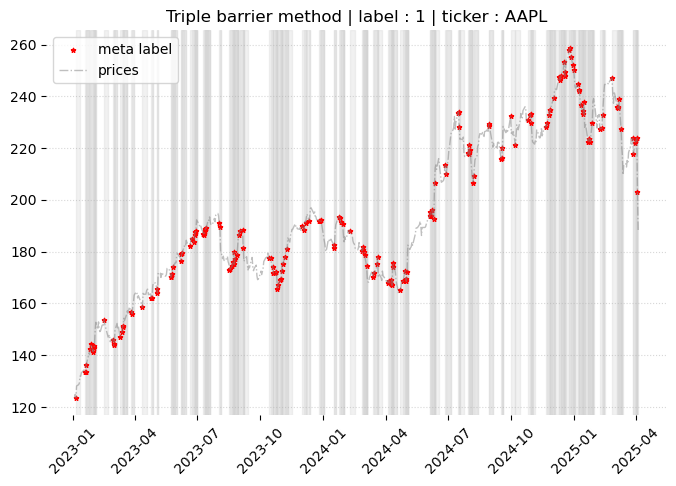

In [9]:
fig, ax = plt.subplots(figsize = (8, 5))
for idx in meta_labels[meta_labels['bin'] == 1]['2023':].index :
    ax.axvspan(
        idx, 
        triple_barrier_events.loc[idx]['t1'], 
        color = 'lightgray', 
        alpha = 0.3
    )
ax.scatter(
    meta_labels[meta_labels['bin'] == 1]['2023':].index,
    data.loc[meta_labels[meta_labels['bin'] == 1].index]['2023':]['Close'],
    marker = '*',
    color = 'red',
    s = 10,
    label = 'meta label'
)
ax.plot(
    data['2023':]['Close'],
    alpha = 0.5,
    color = 'gray',
    lw = 1,
    label = 'prices',
    ls = '-.'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 

plt.xticks(rotation = 45)
ax.legend()
plt.title('Triple barrier method | label : 1 | ticker : AAPL')
plt.show()

### How to use Meta Labeling

binary classification 문제는 1종 오류(false positive)와 2종 오류(false negative) 간의 trade-off이다. 대개 binary classifier의 참 양성률을 올리다 보면 거짓 양성률이 증가한다. 분류 모형의 ROC(Receiver Operating Curve)는 true positive rate가 증가해 발생하는 비용을 측정하는데, 높은 false positive rate를 수용하는 관점에서 측정한다

아래의 그림은 이른바 Confusion matrix를 시각화한 것이다. 관측값 집합 중에서 조건에 부합하는 아이템과 조건에 부합하지 않는 아이템이 있다. binary classifier는 특정 아이템이 조건을 보이는지를 예측하는 것으로(타원), TP 영역은 True positive를 포함하고, TN 영역은 True negative를 포함한다. 이는 두 종류의 오류인 False positive와 False negative를 야기한다. **precision**은 TP영역과 타원 영역간의 비율이고, **recall**은 TP영역과 왼쪽 사각형 영역 간의 비율이다. 분류 문제에 있어서 이런 개념의 recall rate는 가설 검증에 있어서 검증력과 유사하다. **accuracy**는 TP와 TN 영역의 합을 전체 아이템으로 나눈 것이다. 

대개 FP영역을 감소시키면 FN영역이 증가하는데, 그 이유는 일반적으로 높은 정밀도는 더 적은 수의 예측을 의미하고 이는 **recall rate**을 낮추기 때문이다. 한편, 분류기 전체의 효율성을 극대화시키는 precision과 recall사이의 조합도 존재한다. **f1-score**는 분류기의 효율성을 측정하는데 precision과 recall 사이의 조화 평균을 사용해 측정한다.

<img src="https://lh3.googleusercontent.com/a34GCCUUjiJDedpXXfJqEUGDFe978H1qkz0qMiqsz4G5UknjGgPy3px8PNlLnhbT_N9URPFn526aKWjGvzjh8Z9Wb-xHHTYlS_GhbeJO5w-3JHwY5aKMpQMqiQ7EngFhHg" width="200px" height="100px" title="F1 score"/>

Meta Labeling은 더 높은 F1 score를 원할 경우에 특히 더 유용하다. 그 이유는 다음과 같다

1. 정밀도는 그다지 높지 않더라도 높은 재현율을 갖는 모델을 구축할 수 있다.
2. Primary Model에서 예측된 양성에 대해 Meta Labeling을 적용해 낮은 정밀도를 교정할 수 있다.

Meta Labeling을 사용하면 거짓 양성을 걸러 F1 score를 향상시킬 것이고, 대부분의 양성은 이미 Primary model에 의해 식별된 상태다. 달리 표현하면 Meta Model의 역할은 Primary Model에 의해 결정된 양성이 참인지 거짓인지를 판별하는 것이다. 즉 베팅 기회를 측정하는 것이 목적이 아니라 제안된 베팅을 실행할 것인지 실행하지 않을 것인지를 결정하는 것이 목적이다.

Meta Labeling이 강력한 도구인 이유는 다음과 같은 이유 때문이다.

1. 머신러닝 알고리즘은 종종 블랙박스라는 점에서 공격을 받는다. Meta Labeling은 머신러닝 시스템을 화이트박스 위에 구축할 수 있다. Fundamental 모델을 Machine Learning 모델로 변환할 수 있는 능력을 가진 Meta Labeling 모델은 특히 Quantamental 회사에서 유용하다.
2. Meta Labeling을 적용하면 과적합효과가 억제된다. Machine Learning이 베팅의 방향을 결정하는 것이 아니라 크기만을 결정하기 때문이다.
3. Meta Labeling은 베팅 크기 예측과 베팅 방향 예측을 분리함으로써 정교한 전략 구조가 가능해진다. 예를 들어서, 랠리를 주도하는 특성과 급락을 주도하는 특성은 다르다는 점을 고려해야 한다. 이 경우 Primary Model의 매수 추천에 기초해 매수 포지션만 고려하는 머신러닝 전략을 개발하거나 완전히 다른 Primary Model의 매도 추천에 따라 매도 포지션에 대해서만 전략을 수립하는 머신러닝을 개발할 수 있다. 
4. 작은 베팅에 높은 정확도나 높은 베팅에 낮은 정확도를 갖는 것은 일을 망치는 길이다. 호기를 참지하는 것만큼 중요한 것은 적절한 베팅 크기를 설정하는 일이다. 따라서 중대한 결정을 정확하게 수행하는 머신러닝 알고리즘을 집중적으로 개발하는 것은 상당히 합리적인 일이 된다. 이 네 번째 사항에 대해서는 차후 10장에서 다시 알아본다.

저자(Prado)의 경험상 Meta Labeling 머신러닝 모형은 표준 레이블링 모형보다 더욱 강건하고 신뢰성 있는 결과를 갖다준다.